### Import required packages

In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting

from prettytable import PrettyTable  # To print in tabular format


from sklearn.model_selection import train_test_split
# Different Models
from sklearn.linear_model import LogisticRegression  # LR
from sklearn.svm import LinearSVC  # SVM
from sklearn.tree import DecisionTreeClassifier  #DT
from sklearn.ensemble import RandomForestClassifier  # RF
import xgboost as xgb  #XGB

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer  # Scoring functions
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score  # Scoring fns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # Cross validation
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 


%matplotlib inline

# Helper Functions

In [2]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(X_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['attack', 'non-attack'],
           yticklabels=['attack', 'non-attack']);
    plt.xlabel('prediction')
    plt.ylabel('actual')


In [3]:
def false_alarm_rate(y_true, y_pred):
    """
    This function will return False Alarm Rate for given true and predicted values.
    False Alarm Rate is average of False Negetive Rate and False Positive Rate
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    FPR = fp / (fp + tn)  # False positive rate
    FNR = fn / (fn + tp)  # False negetive rate
    return (FPR+FNR)/2  # False alarm rate

def evaluate_result(clf, x_train, y_train, x_test, y_test, model_name):
    """ 
    Utility function to get result on test data from best found classifier using hyper parameter tuning.
    Print the accuracy and False Alarm Rate for both train and test.
    Plot confusion matrix of train and test.
    """
    cmap=sns.light_palette("blue")
    labels= ['non-attack', 'attack']
    
    # Training te best model
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)  # prediction on train data
    y_test_pred = clf.predict(x_test)  # prediction on test data
    
    # auc curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # Scores of train dataset
    train_auc = auc(train_fpr, train_tpr)
    train_f1 = f1_score(y_train, y_train_pred)
    train_far = false_alarm_rate(y_train, y_train_pred)
    
    # Scores of test dataset
    test_auc = auc(test_fpr, test_tpr)
    test_f1 = f1_score(y_test, y_test_pred)
    test_far = false_alarm_rate(y_test, y_test_pred)
    
    # Printing the result as a table
    x = PrettyTable()
    x.field_names = ['Dataset', 'Model', 'AUC', 'F1-score', 'False Alarm Rate']
    x.add_row(['Train', model_name, train_auc, train_f1, train_far])
    x.add_row(['Test', model_name, test_auc, test_f1, test_far])
    print(x)

    # Plot AUC curve
    plt.figure()
    plt.plot(train_fpr, train_tpr, label=f"Train AUC: {train_auc}")
    plt.plot(test_fpr, test_tpr, label=f"Test AUC: {test_auc}")
    plt.grid()
    plt.legend()
    plt.show()

    # Confusion martix of train and test
    # Train confusion matrix
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Train Confusion Matrix")

    # Test confusion matrix
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Confusion Matrix")
    plt.show()
    
    # Returning scores of test data
    return clf, test_auc, test_f1, test_far

### Import our data and prepare it for modeling

In [6]:
X = pd.read_csv('/Users/user/T5/PROJECT/Classification/data/pre-processed-x_train-data.csv')
y = pd.read_csv('/Users/user/T5/PROJECT/Classification/data/pre-processed-y_train-data.csv')


In [7]:
df = X.join(y)

In [9]:
train= df.copy(deep=True)

In [10]:
del df, X, y

In [ ]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]

In [12]:
del train

### Split our data into train/test

In [13]:
X_train, X_test, y_train, X_test = train_test_split(X, y, test_size=0.25, random_state=42)

### KNeighborsClassifier

+---------+----------------------+--------------------+--------------------+----------------------+
| Dataset |        Model         |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+----------------------+--------------------+--------------------+----------------------+
|  Train  | KNeighborsClassifier | 0.9440841762311307 | 0.9684094113743813 | 0.055915823768869444 |
|   Test  | KNeighborsClassifier | 0.9183232246778243 | 0.9528693609488992 | 0.08167677532217577  |
+---------+----------------------+--------------------+--------------------+----------------------+


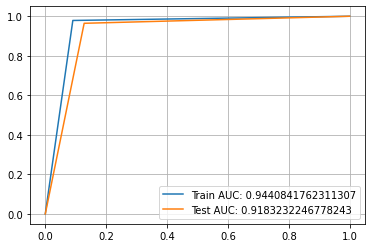

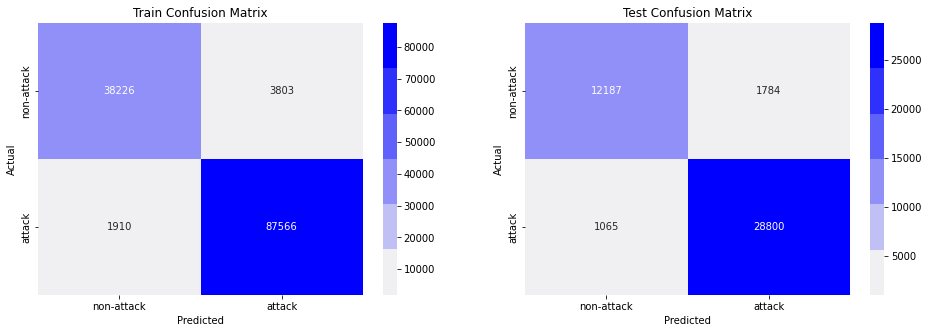

(KNeighborsClassifier(),
 0.9183232246778243,
 0.9528693609488992,
 0.08167677532217577)

In [14]:
knn = KNeighborsClassifier()
evaluate_result(knn,X_train,y_train,X_test,y_test,"KNeighborsClassifier")

###  KNeighborsClassifier GridSearchCV

In [30]:
# define the parameter values that should be searched
k_range = list(range(20, 31))
weight_options = ['uniform', 'distance']
# metric_options = ['euclidean', 'manhattan', 'minkowski']

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)#, metric=metric_options)


# instantiate and fit the grid
grid = GridSearchCV(knn, param_grid, scoring='accuracy', error_score=0, n_jobs=2)
grid.fit(X, y)

# examine the best model
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

this should be the output of the grid search for KNN
* Best params:  {'n_neighbors': 29, 'weights': 'uniform'}
* Best estimator:  KNeighborsClassifier(n_neighbors=29)
* Best score:  0.9038215177890937

### Using the best parameters to make predictions

+---------+----------------------+--------------------+--------------------+---------------------+
| Dataset |        Model         |        AUC         |      F1-score      |   False Alarm Rate  |
+---------+----------------------+--------------------+--------------------+---------------------+
|  Train  | KNeighborsClassifier | 0.9173352263350654 | 0.9591222101030491 | 0.08266477366493466 |
|   Test  | KNeighborsClassifier | 0.910010191520708  | 0.9554264195045937 | 0.08998980847929203 |
+---------+----------------------+--------------------+--------------------+---------------------+


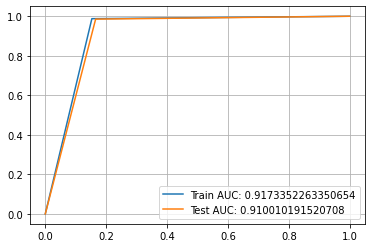

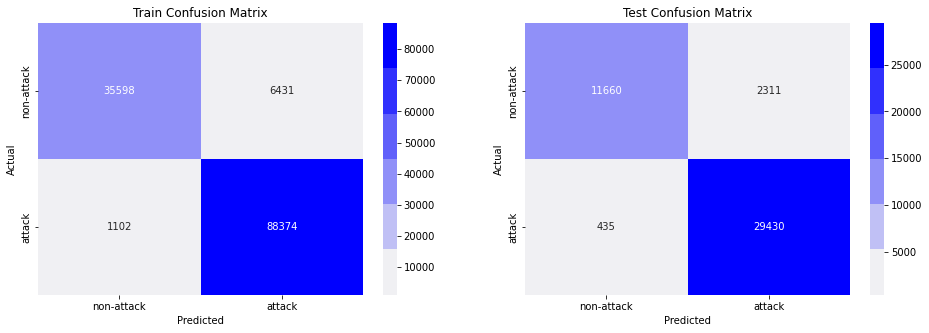

(KNeighborsClassifier(n_jobs=-1, n_neighbors=29),
 0.910010191520708,
 0.9554264195045937,
 0.08998980847929203)

In [23]:
knn = KNeighborsClassifier(n_neighbors=29,n_jobs=-1)
evaluate_result(knn,X_train,y_train,X_test,y_test,"KNeighborsClassifier")

### LogisticRegression: Baseline

+---------+--------------------+--------------------+--------------------+---------------------+
| Dataset |       Model        |        AUC         |      F1-score      |   False Alarm Rate  |
+---------+--------------------+--------------------+--------------------+---------------------+
|  Train  | LogisticRegression | 0.9030549141659968 | 0.9534347774582969 | 0.09694508583400326 |
|   Test  | LogisticRegression | 0.899854085349573  | 0.9523395345091408 | 0.10014591465042695 |
+---------+--------------------+--------------------+--------------------+---------------------+


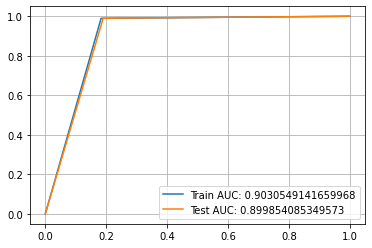

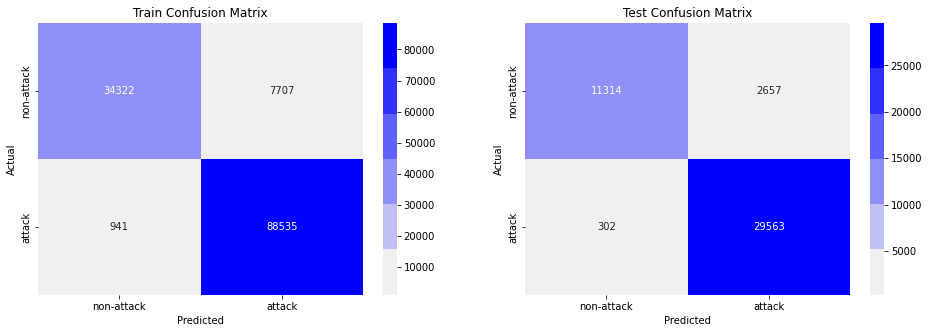

(LogisticRegression(),
 0.899854085349573,
 0.9523395345091408,
 0.10014591465042695)

In [14]:
lr = LogisticRegression()
evaluate_result(lr,X_train,y_train,X_test,y_test,"LogisticRegression")

###  LogisticRegression: GridSearchCV

In [19]:
# define the parameter values that should be searched
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(solver=solvers,penalty=penalty,C=c_values)


# instantiate and fit the grid
grid = GridSearchCV(lr, param_grid, scoring='accuracy', error_score=0,n_jobs=-1)
grid.fit(X, y)

# examine the best model
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Best params:  {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best estimator:  LogisticRegression(C=100, solver='newton-cg')
Best score:  0.9191629839829233


### LogisticRegression: Using the best parameters to make predictions

+---------+--------------------+--------------------+--------------------+---------------------+
| Dataset |       Model        |        AUC         |      F1-score      |   False Alarm Rate  |
+---------+--------------------+--------------------+--------------------+---------------------+
|  Train  | LogisticRegression | 0.9052662312910673 | 0.9544028716489344 | 0.09473376870893259 |
|   Test  | LogisticRegression | 0.9021047580765797 | 0.9534891216760676 | 0.09789524192342026 |
+---------+--------------------+--------------------+--------------------+---------------------+


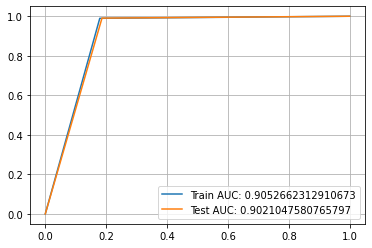

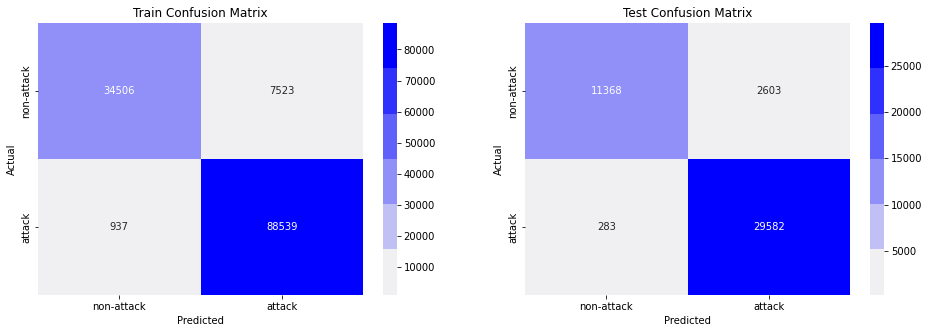

(LogisticRegression(C=100, solver='newton-cg'),
 0.9021047580765797,
 0.9534891216760676,
 0.09789524192342026)

In [17]:
lr = LogisticRegression(C=100, solver='newton-cg')
evaluate_result(lr,X_train,y_train,X_test,y_test,"LogisticRegression")

# Decision Tree: Baseline

+---------+---------------+--------------------+--------------------+----------------------+
| Dataset |     Model     |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+---------------+--------------------+--------------------+----------------------+
|  Train  | Decision Tree | 0.9965526447930385 | 0.9978207907735633 | 0.003447355206961472 |
|   Test  | Decision Tree | 0.9344917852187251 | 0.9587304772415638 | 0.06550821478127489  |
+---------+---------------+--------------------+--------------------+----------------------+


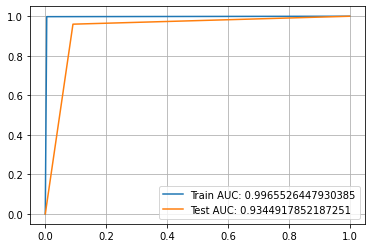

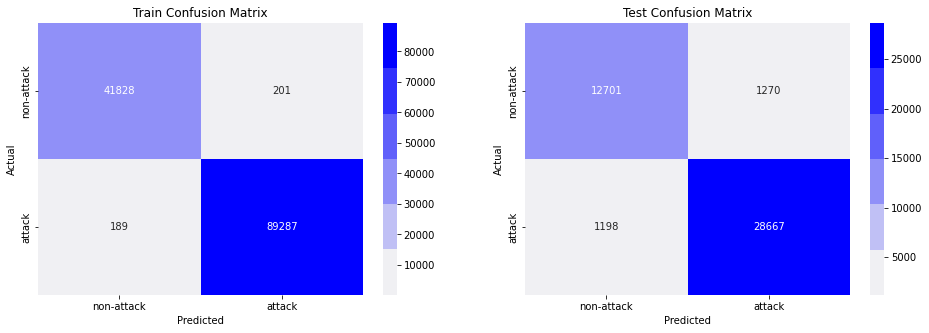

(DecisionTreeClassifier(),
 0.9344917852187251,
 0.9587304772415638,
 0.06550821478127489)

In [21]:
dt= DecisionTreeClassifier()
evaluate_result(dt,X_train,y_train,X_test,y_test,"Decision Tree")

### Decision Tree: Grid Search

In [24]:
# define the parameter values that should be searched
criterion = ['gini', 'entropy']
splitter= ["best"]
max_depth = [2,4,6,8,10]
min_samples_split= [2,3]
min_samples_leaf= [1]
min_weight_fraction_leaf= [0]
min_impurity_decrease= [0]
ccp_alpha= [0]

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(
    criterion=criterion,
    splitter=splitter,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    min_weight_fraction_leaf=min_weight_fraction_leaf,
    min_impurity_decrease=min_impurity_decrease,
    ccp_alpha=ccp_alpha
    )


# instantiate and fit the grid
grid = GridSearchCV(dt, param_grid, scoring='accuracy', error_score=0, n_jobs=-1)
grid.fit(X, y)

# examine the best model
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Best params:  {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 4, 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}
Best estimator:  DecisionTreeClassifier(ccp_alpha=0, criterion='entropy', max_depth=4,
                       min_impurity_decrease=0, min_weight_fraction_leaf=0)
Best score:  0.9215125553958913


(*, criterion="gini", splitter="best", max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0, class_weight=None, ccp_alpha=0)

### Decision Tree: Using the best parameters to make predictions

+---------+---------------+--------------------+--------------------+---------------------+
| Dataset |     Model     |        AUC         |      F1-score      |   False Alarm Rate  |
+---------+---------------+--------------------+--------------------+---------------------+
|  Train  | Decision Tree | 0.8926554435412523 | 0.9517518178237216 | 0.10734455645874781 |
|   Test  | Decision Tree | 0.8882246323472446 | 0.9500780031201247 | 0.11177536765275534 |
+---------+---------------+--------------------+--------------------+---------------------+


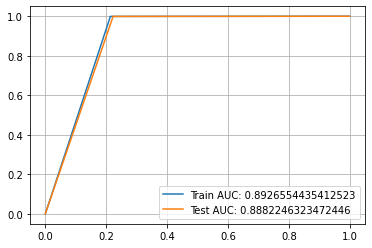

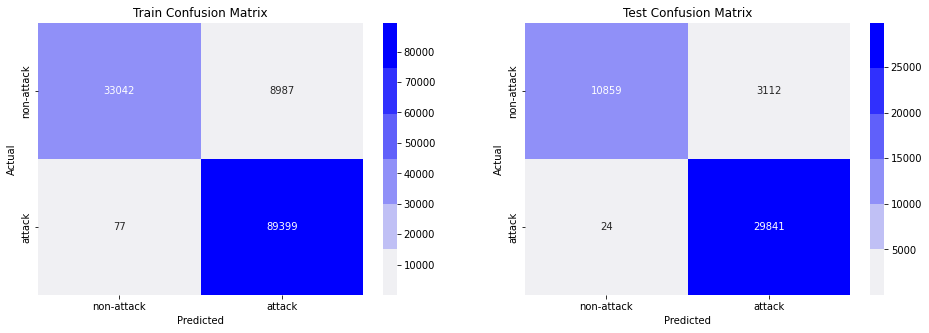

(DecisionTreeClassifier(ccp_alpha=0, criterion='entropy', max_depth=4,
                        min_impurity_decrease=0, min_weight_fraction_leaf=0),
 0.8882246323472446,
 0.9500780031201247,
 0.11177536765275534)

In [25]:
dt= DecisionTreeClassifier(ccp_alpha=0, criterion='entropy', max_depth=4,
                       min_impurity_decrease=0, min_weight_fraction_leaf=0)
evaluate_result(dt,X_train,y_train,X_test,y_test,"Decision Tree")

# Random Forest

+---------+---------------+--------------------+--------------------+-----------------------+
| Dataset |     Model     |        AUC         |      F1-score      |    False Alarm Rate   |
+---------+---------------+--------------------+--------------------+-----------------------+
|  Train  | Random Forest | 0.9961047443488291 | 0.9978225185085926 | 0.0038952556511709763 |
|   Test  | Random Forest | 0.9418390307741216 | 0.9679808248615587 |  0.058160969225878344 |
+---------+---------------+--------------------+--------------------+-----------------------+


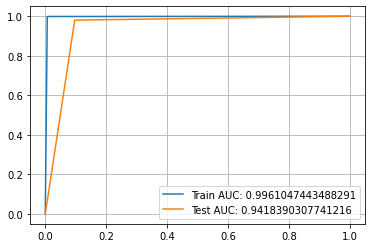

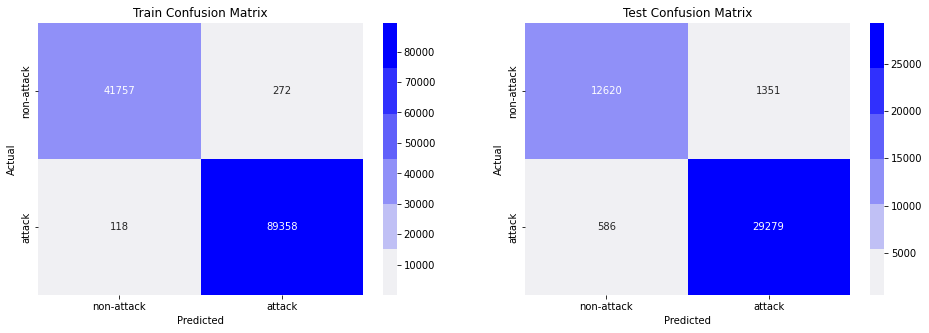

(RandomForestClassifier(),
 0.9418390307741216,
 0.9679808248615587,
 0.058160969225878344)

In [24]:
rf= RandomForestClassifier()
evaluate_result(rf,X_train,y_train,X_test,y_test,"Random Forest")

In [25]:
# define the parameter values that should be searched
bootstrap= [True]
max_depth = [80, 90, 100, 110]
max_features = [2, 3]
min_samples_leaf = [3, 4, 5]
min_samples_split =  [8, 10, 12]
n_estimators = [100, 200, 300, 1000]

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(
        bootstrap=bootstrap,
         max_depth=max_depth,
         max_features=max_features,
         min_samples_leaf=min_samples_leaf,
         min_samples_split=min_samples_split,
         n_estimators=n_estimators
       )


# instantiate and fit the grid
grid = GridSearchCV(rf, param_grid, scoring='accuracy', error_score=0, n_jobs=-1)
grid.fit(X, y)

# examine the best model
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Best params:  {'bootstrap': True, 'max_depth': 90, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 100}
Best estimator:  RandomForestClassifier(max_depth=90, max_features=2, min_samples_leaf=5,
                       min_samples_split=12)
Best score:  0.9176915105293423


+---------+---------------+--------------------+--------------------+---------------------+
| Dataset |     Model     |        AUC         |      F1-score      |   False Alarm Rate  |
+---------+---------------+--------------------+--------------------+---------------------+
|  Train  | Random Forest | 0.9143828827039622 | 0.9612658839964537 | 0.08561711729603783 |
|   Test  | Random Forest | 0.9028441313518017 | 0.9560002565582708 | 0.09715586864819827 |
+---------+---------------+--------------------+--------------------+---------------------+


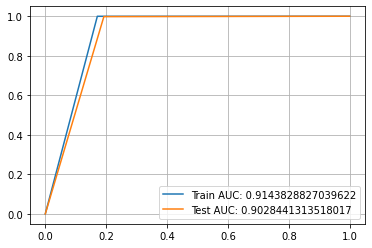

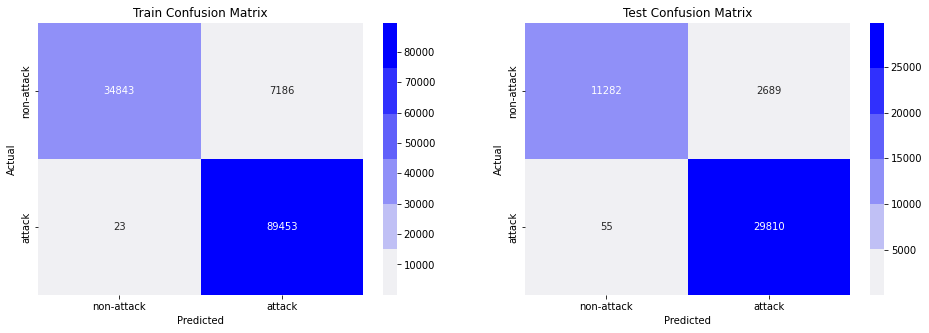

(RandomForestClassifier(max_depth=90, max_features=2, min_samples_leaf=5,
                        min_samples_split=12),
 0.9028441313518017,
 0.9560002565582708,
 0.09715586864819827)

In [22]:
rf= RandomForestClassifier(max_depth=90, max_features=2, min_samples_leaf=5,
                       min_samples_split=12)
evaluate_result(rf,X_train,y_train,X_test,y_test,"Random Forest")

In [27]:
gbm = xgb.XGBClassifier( 
                        n_estimators=400,
                        max_depth=12,
                        # objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.1,
                        # min_child_weight=3,
                        # colsample_bytree=.8,
                        colsample_bylevel=.5,
                        n_jobs=-1
                       )

eval_set=[(X_train,y_train),(X_test,y_test)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=75,
                    verbose=False
                   )

acc= accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 

In [28]:
print(acc)

0.9534857194999544


[12:51:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
+---------+-------+--------------------+--------------------+---------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate  |
+---------+-------+--------------------+--------------------+---------------------+
|  Train  |  XGB  | 0.9669747148588889 | 0.9819451758640759 | 0.03302528514111119 |
|   Test  |  XGB  | 0.9391323262317678 | 0.9665130263831756 | 0.06086767376823219 |
+---------+-------+--------------------+--------------------+---------------------+


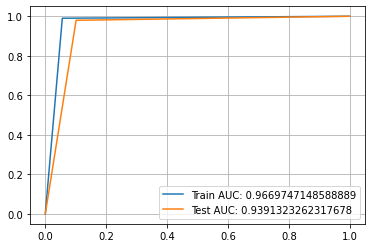

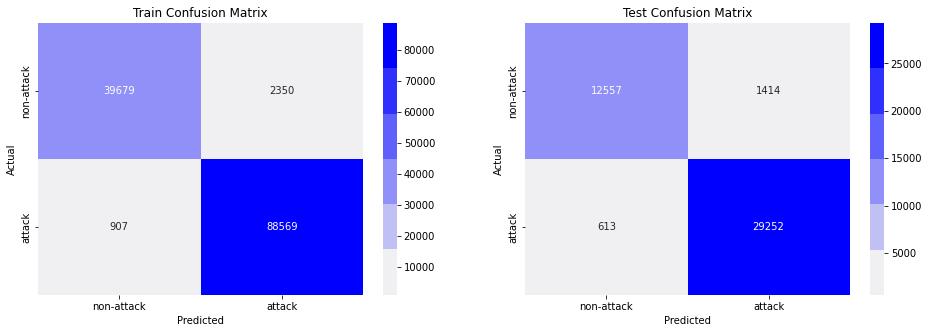

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.05, max_delta_step=0,
               max_depth=12, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=400, n_jobs=-1,
               num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.1,
               tree_method='exact', validate_parameters=1, verbosity=None),
 0.9391323262317678,
 0.9665130263831756,
 0.06086767376823219)

In [28]:
evaluate_result(gbm,X_train,y_train,X_test,y_test,"XGB")

In [ ]:
# define the parameter values that should be searched
n_estimators=400
max_depth= 12
# objective='binary:logistic', #new objective
learning_rate=.05
subsample=.1
# min_child_weight=3,
# colsample_bytree=.8,
colsample_bylevel=.5
n_jobs=-1

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(
        bootstrap=bootstrap,
         max_depth=max_depth,
         max_features=max_features,
         min_samples_leaf=min_samples_leaf,
         min_samples_split=min_samples_split,
         n_estimators=n_estimators
       )


# instantiate and fit the grid
grid = GridSearchCV(rf, param_grid, scoring='accuracy', error_score=0, n_jobs=-1)
grid.fit(X, y)

# examine the best model
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)